In [27]:
import os
import tarfile
import urllib

In [44]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

fetch_housing_data()



In [47]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:>

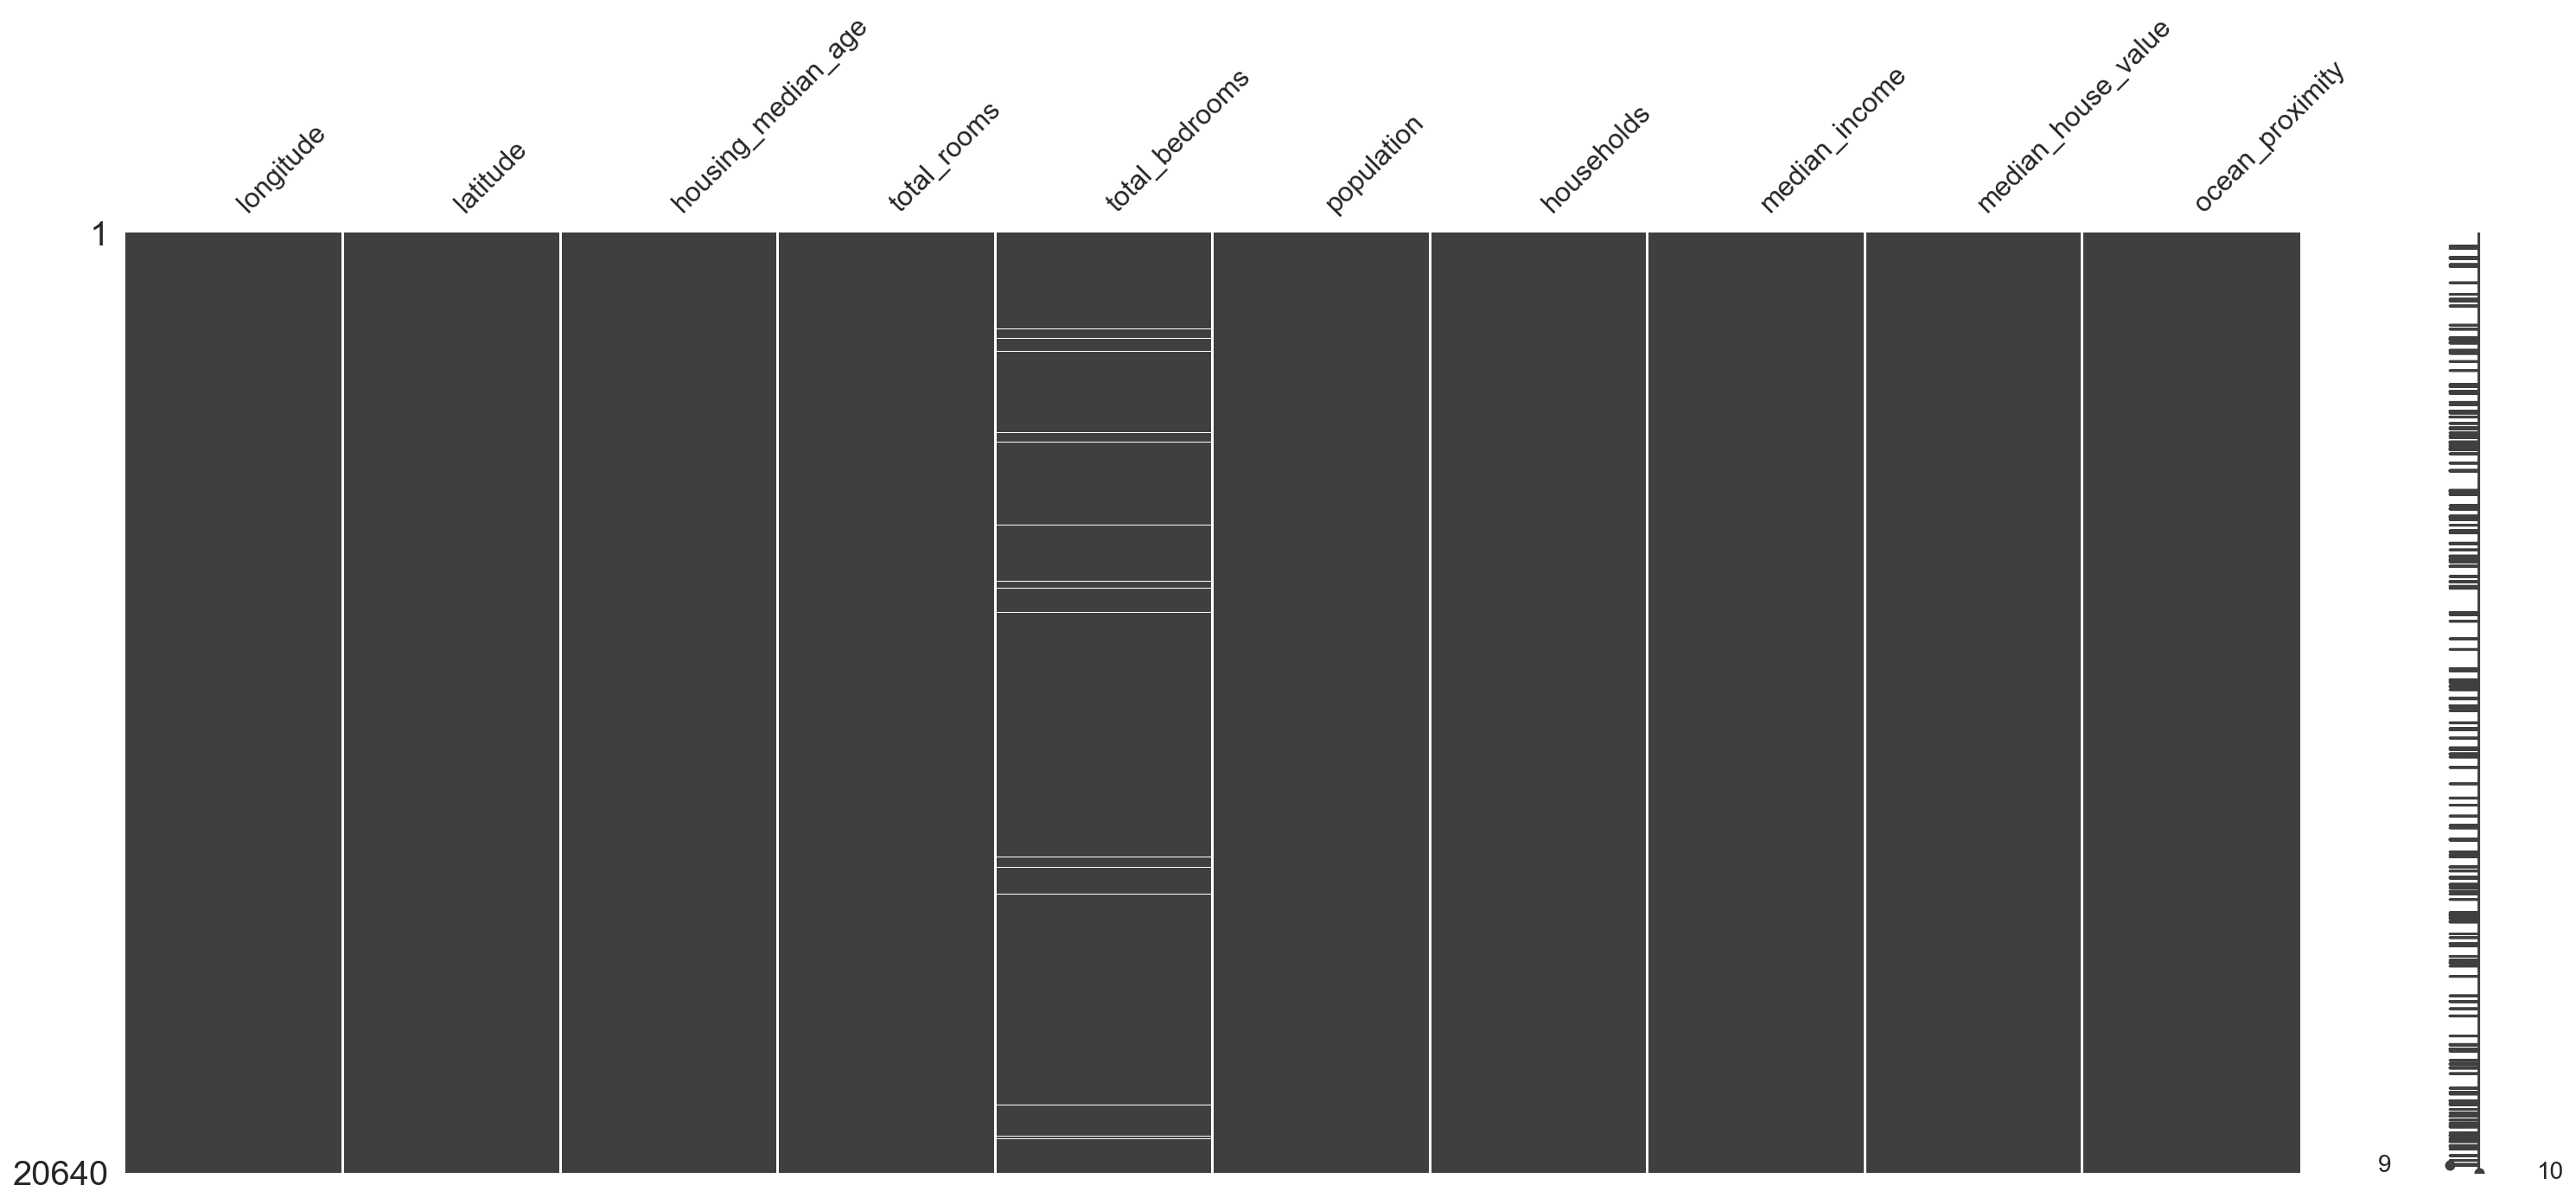

In [55]:
msno.matrix(housing)

In [56]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

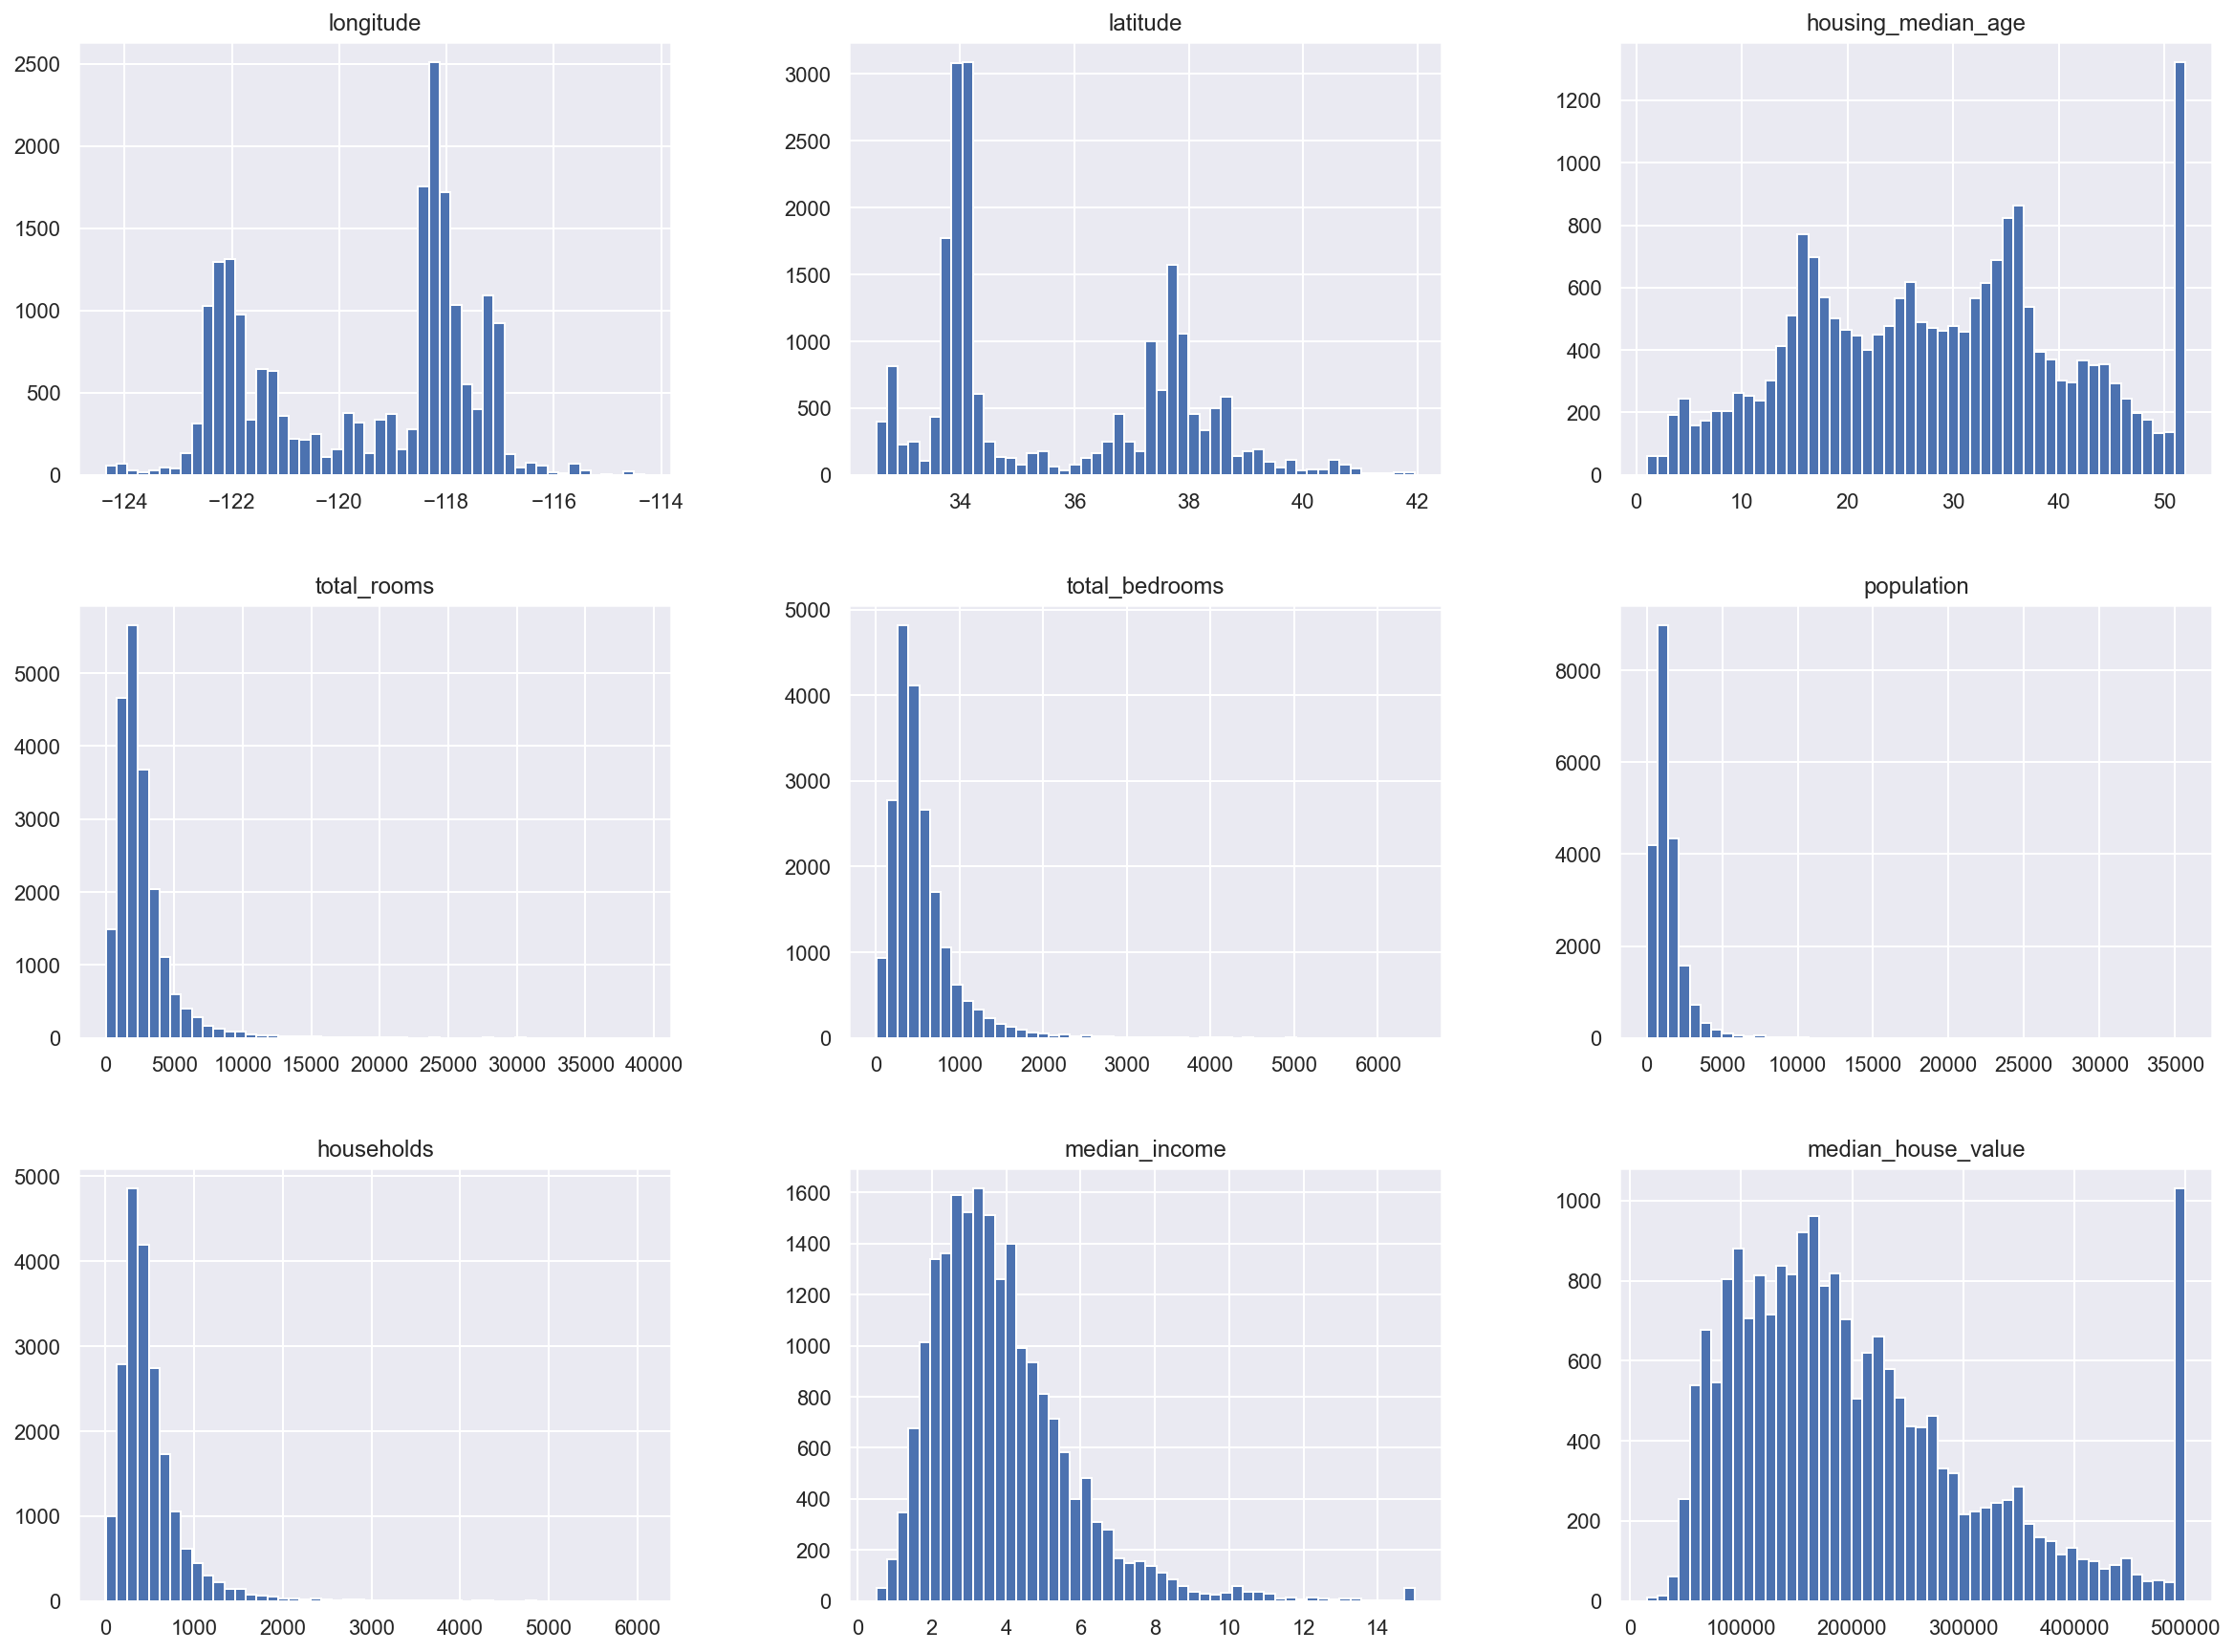

In [58]:
housing.hist(bins=50,figsize=(20,15))
plt.show()

<h3>train data /test data 나누기</h3>

In [59]:
#실행 할 때마다 지속적으로 바뀐다
def split_train_test(data,test_radio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_radio)
    test_indices = shuffled_indices[:text_set_size]
    train_indices = shuffled_indices[test_set_size]
    return data.iloc(train_indices), data.iloc[test_indices]

In [76]:
from zlib import crc32 # 헤시값을 기준으로 전체 데이터보다 20% 낮으면  테스트 세트
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio*2**32

In [77]:
def split_train_test_by_id(data, test_ratio,id_column):
    ids =data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [78]:
housing_with_id = housing.reset_index() 
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"index") #20%로 테스트 셋 트레인 셋 나눔

In [85]:
#고유 식별자가 없는 경우 데이터가 업데이트가 되면 지속적으로 사용이 불가능해 고유 식별자를 대체할 수 있는 위도 경도를 합하여 인댁스화 한다
housing_with_id["id"] = housing["longitude"]*1000+housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"index")
housing_with_id["id"] 

0       -122192.12
1       -122182.14
2       -122202.15
3       -122212.15
4       -122212.15
           ...    
20635   -121050.52
20636   -121170.51
20637   -121180.57
20638   -121280.57
20639   -121200.63
Name: id, Length: 20640, dtype: float64

In [82]:
#사이킷 런을 사용한 데이터 분리 train_test_split, split_train_test와 비슷하나 두가지 특징 존제
#1. random_state 매개변수, 2. 행의 개수가 같은 여러개의 데이터셋을 넘겨서 같은 인덱스 기반으로 나눌 수 있다
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
#계층적 셈플링 stratified sampling
#train, test set을 뽑을 때 대표성을 위해서 데이터의 특징을 반드시 반영 예) 전 인구가 남자 6 : 여자 4 라면 test set 도 반드시 6:4를 따라야 한다 이를 이라고 한다
#계층별로 충분한 데이터가 있어야 한다 

In [83]:
#housing data 중위소득 계층화
housing["income_cat"] = pd.cut(housing["median_income"],
                                                      bins= [0.,1.5,3.0,4.5,6., np.inf],
                                                      labels=[1,2,3,4,5])

<AxesSubplot:>

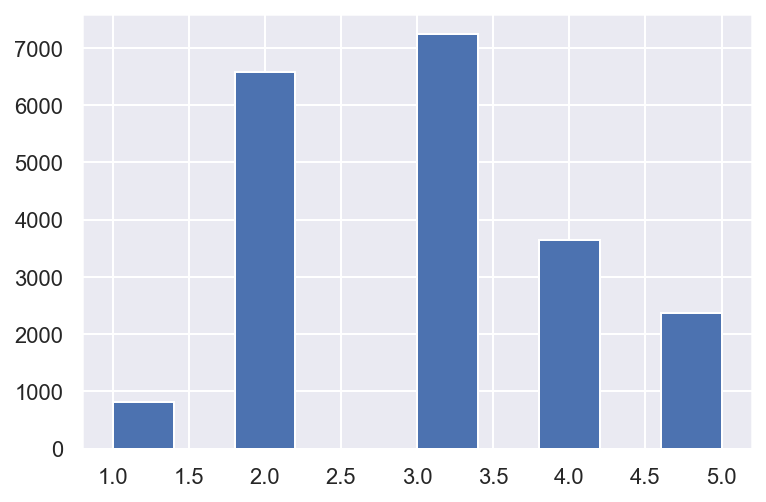

In [84]:
housing["income_cat"].hist()

In [87]:
#계층적 셈플링
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [93]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [95]:
#income_cat 지우기
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<h3>데이터 이해를 위한 탐색과 시각화</h3>

In [96]:
housing = strat_train_set.copy()

1. 지리적 데이터 시각화

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

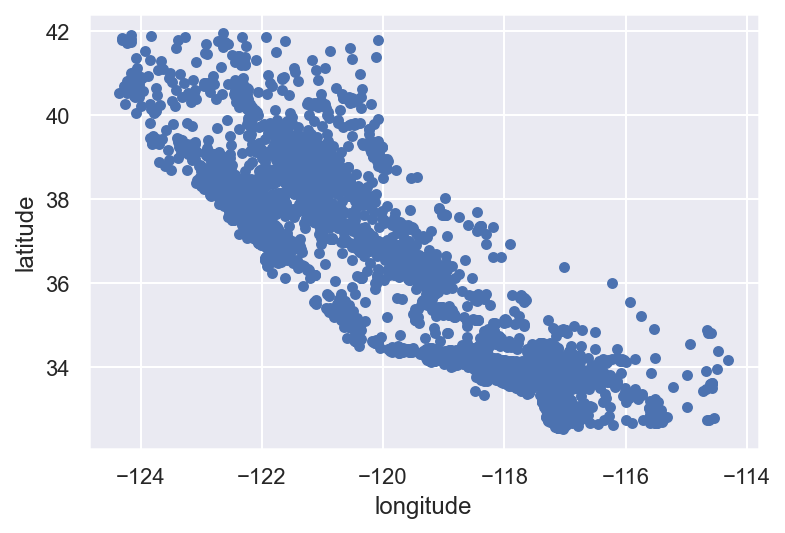

In [98]:
housing.plot(kind="scatter", x="longitude",y="latitude")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

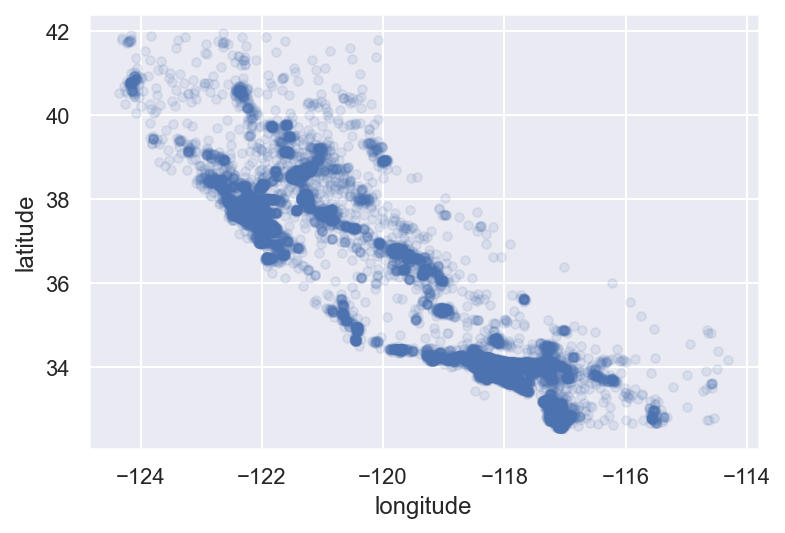

In [100]:
#alpha = 0.1, 밀집된 데이터를 잘 보여줌
housing.plot(kind="scatter", x="longitude",y="latitude",alpha = 0.1)